In [1]:
import cv2
import uuid
import h5py
import time
import tqdm
import shutil
import pathlib
import warnings

warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Layer

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
del gpu, gpus

matplotlib.style.use('dark_background')
%matplotlib inline

## __Константы__

In [2]:
POSITIVE_DATA_PATH = pathlib.Path('positive')
NEGATIVE_DATA_PATH = pathlib.Path('negative')
ANCHOR_DATA_PATH   = pathlib.Path('anchor')

IMAGE_SIZE         = (105, 105)
BATCH_SIZE         = 32
AUTOTUNE           = tf.data.experimental.AUTOTUNE

FACE_DETECTOR      = cv2.dnn.readNetFromCaffe(
    'cascades/deploy.prototxt.txt', 
    'cascades/res10_300x300_ssd_iter_140000.caffemodel'
)

## __API__

## **Содержание**

#### 1. **[Загрузка данных](#download)**
#### 2. **[Обработка данных](#process)**
#### 3. **[Построение модели](#build-it)**
#### 4. **[Обучение модели](#teach-it)**
#### 5. **[Валидация модели](#validate)**
#### 6. **[Выгрузка модели](#upload)**
#### 7. **[Проверка на реальном примере](#real-time)**

<a name="download"></a>
#### 1. **Загрузка данных**

In [3]:
class DataLoader:
    """Data workflow for downloading, moving and getting lfw and external data.
    
    Attributes
    ----------
    url: str
        The url source from which the file will be downloaded.
    storage_file: str
        Name of the file in which will data be stored.
    dataset_path: str
        Path to the donwloaded lfw dataset.
    """
    url          = 'http://vis-www.cs.umass.edu/lfw/lfw.tgz'
    storage_file = 'lfw.h5'
    
    def __init__(self, url: str=None, storage_file: str=None) -> None:
        self.url           = url if url else self.url
        self.storage_file  = storage_file if storage_file else self.storage_file
        self._dataset_path = None
    
    @property
    def dataset_path(self) -> str:
        """Gets dataset_path.
        
        Returns
        -------
        str: Path to the donwloaded lfw dataset.
        """
        return self._dataset_path
    
    @dataset_path.setter
    def dataset_path(self, dataset_path: str) -> None:
        """Sets dataset_path, if required.
        
        Attributes
        ----------
        dataset_path: str
            Path to a dataset.
        """
        self._dataset_path = dataset_path
    
    def download_lfw_dataset(self) -> (str, bool):
        """Download lfw dataset and sets dataset_path attribute.
        
        Returns
        -------
        str: status message of execution.
        bool: status integer.
        """
        try:
            self._dataset_path = tf.keras.utils.get_file(
                fname='lfw',
                origin=self.url, 
                untar=True
            )
            return 'LFW dataset was successfully downloaded!', 1
        
        except Exception as e:
            return e, 0
    
    def save(self, data: np.ndarray, dataset: str) -> (str, bool):
        """Saves specified data to the storage_file.
        
        Attributes
        ----------
        data: np.ndarray
            Single or collection of data which will be saved to the storage_file.
        dataset: str
            Dataset name.
        
        Returns
        -------
        str: status message of execution.
        bool: status integer.
        """
        try:
            with h5py.File(self.storage_file, 'a', driver=None) as h5:
                h5.create_dataset(
                    dataset, shape=data.shape, dtype=h5py.h5t.IEEE_F16BE, data=data
                )

            return f'Data was successfully saved in {self.storage_file}!', 1
        
        except Exception as e:
            return e, 0
    
    def load(self, dataset: str) -> (np.ndarray | None, str, bool):
        """Loads specified data to the storage_file.
        
        Attributes
        ----------
        dataset: str
            Dataset name.
        
        Returns
        -------
        np.ndarray | None: loaded data. If None was returned, an error occured.
        str: status message of execution.
        bool: status integer.
        """
        try:
            data_file = h5py.File(self.storage_file, 'r', driver=None)
            data = np.array(data_file[f'/{dataset}']).astype('float32')
            data_file.close()
            return data, f'Data was successfully loaded from {self.storage_file}', 1
        
        except Exception as e:
            return None, e, 0
    
    def delete(self) -> (str, bool):
        """Deletes the storage_file.
        
        Returns
        -------
        str: status message of execution.
        bool: status integer.
        """
        try:
            pathlib.Path(self.storage_file).unlink()
            return f'{self.storage_file} was successfully deleted!', 1
        except Exception as e:
            return e, 0

In [4]:
def load_positive_negative_anchor_images_to_h5(
    temp_anchor_path: str, temp_positive_path: str, temp_negative_path: str, data_loader: DataLoader
) -> (str, bool):
    """Loads anchor, positive and negative images from temporary directories to h5 storage.
    
    Attributes
    ----------
    temp_anchor_path: str
        Temporary anchor directory of images that will be uploaded.
    temp_positive_path: str
        Temporary positive directory of images that will be uploaded.
    temp_negative_path: str
        Temporary negative directory of images that will be uploaded.
    data_loader: DataLoader
        The DataLoader object that will be used to upload data.
    
    Returns
    -------
        str: status message of execution.
        bool: status integer.
    """
    anchor_images_buffer   = []
    positive_images_buffer = []
    negative_images_buffer = []
    
    temp_anchor_path   = pathlib.Path(temp_anchor_path)
    temp_positive_path = pathlib.Path(temp_positive_path)
    temp_negative_path = pathlib.Path(temp_negative_path)
    
    try:
        anchor_iter   = list(temp_anchor_path.glob('*.jpg'))
        positive_iter = list(temp_positive_path.glob('*.jpg'))
        negative_iter = list(temp_negative_path.glob('*/*'))
        
        np.random.shuffle(anchor_iter)
        np.random.shuffle(positive_iter)
        np.random.shuffle(negative_iter)

        for anchor_image_path, positive_image_path in zip(anchor_iter, positive_iter):
            anchor_image   = tf.keras.utils.load_img(anchor_image_path)
            positive_image = tf.keras.utils.load_img(positive_image_path)

            anchor_image   = tf.keras.utils.img_to_array(anchor_image)
            positive_image = tf.keras.utils.img_to_array(positive_image)

            anchor_images_buffer.append(anchor_image)
            positive_images_buffer.append(positive_image)
        
        for i, negative_image_path in enumerate(negative_iter):
            negative_image = tf.keras.utils.load_img(negative_image_path)
            negative_image = tf.keras.utils.img_to_array(negative_image)
            negative_images_buffer.append(negative_image)
            if i == len(anchor_images_buffer) - 1:
                break
        
        anchor_images_buffer   = np.array(anchor_images_buffer)
        positive_images_buffer = np.array(positive_images_buffer)
        negative_images_buffer = np.array(negative_images_buffer)
        
        data_loader.save(anchor_images_buffer, dataset=str(ANCHOR_DATA_PATH))
        data_loader.save(positive_images_buffer, dataset=str(POSITIVE_DATA_PATH))
        data_loader.save(negative_images_buffer, dataset=str(NEGATIVE_DATA_PATH))
        
        return "Data is successfully saved to .h5!", 1
    
    except Exception as e:
        return e, 0

In [5]:
def get_faces(image: np.ndarray) -> (np.ndarray, int, int):
    """Apply faces detector to the image.
    
    Attributes
    ----------
    image: np.ndarray
        The image on which faces will be detected.

    Returns
    -------
    np.ndarray: ndarray of faces with specifications.
    int: its width.
    int: its height.
    """
    height, width = image.shape[:2]
    blob = cv2.dnn.blobFromImage(
        cv2.resize(image, (300, 300)),
        1,
        (300, 300),
        (104, 117, 123)
    )
    FACE_DETECTOR.setInput(blob)
    faces = FACE_DETECTOR.forward()
    faces_buff = [(confidence, \
                   int(x1 * width), int(y1 * height), \
                   int(x2 * width), int(y2 * height)) \
                 for _, _, confidence, x1, y1, x2, y2 \
                 in faces[0, 0] if confidence > 0.9]
    
    if faces_buff == []:
        return None, None, None, None
    
    _, x1, y1, x2, y2 = max(faces_buff, key=lambda x: x[0])
    return x1, y1, x2, y2

In [6]:
def record_positive_anchor_images(
    n_samples: int=300,
    create_new: bool=False,
    snap: bool=False,
    prefix: str=None
) -> (pathlib.Path, pathlib.Path):
    """OpenCV real time positive and anchor images receiver.
    
    Parameters
    ----------
    n_samples: int, default=300
        The amount of images will be taken. Both the anchor and the positive directories will have a half of them.
    create_new: bool, default=False
        Whether to truncate existing folders with positive and anchor images or not.
    no_snap: bool, default=False
        Whether to do snaps of the face or not.
    prefix: str
        Prefix of the images names. Required, if no_snap equals False
    
    Returns
    -------
    pathlib.Path: temporary path to the anchor images directory.
    pathlib.Path: temporary path to the positive images directory.
    """
    if snap:
        assert prefix is not None, "Prefix is required while snap is True!"
    
    data_dir     = pathlib.Path('data')
    positive_dir = data_dir / 'positive'
    anchor_dir   = data_dir / 'anchor'
    metadata     = pathlib.Path('metadata')
    
    if create_new:
        try:
            shutil.rmtree(data_dir)
        except FileNotFoundError:
            pass
    
    if not data_dir.exists():
        data_dir.mkdir()
    if not positive_dir.exists():
        positive_dir.mkdir()
    if not anchor_dir.exists():
        anchor_dir.mkdir()
    
    rate = 0
    if snap:
        cam = cv2.VideoCapture(cv2.CAP_ANY)
        uid = uuid.uuid1()
        counter = 0

        pbar = tqdm.tqdm(total=n_samples)
        while cam.isOpened():
            _, frame = cam.read()
            frame = np.flip(frame, axis=1)
            cv2.imshow('Recording in progress...', frame)
            x1, y1, x2, y2 = get_faces(frame)
            
            if x1 and y1 and x2 and y2:
                if not (rate % 3):
                    frame = cv2.resize(frame[y1:y2, x1:x2], (250, 250))

                    if counter < n_samples // 2:
                        path = anchor_dir / f'{prefix}_{str(uid)}.jpg'
                        cv2.imwrite(str(path), frame)
                    else:
                        path = positive_dir / f'{prefix}_{str(uid)}.jpg'
                        cv2.imwrite(str(path), frame)

                    uid = uuid.uuid1()
                    counter += 1
                    pbar.update(1)

                rate += 1
                    
            if cv2.waitKey(1) & 0xFF == ord('q') or counter == n_samples:
                cam.release()
                
        with open(data_dir / metadata, 'a' if (data_dir / metadata).exists() else 'w') as f:
            f.write(prefix + '\n')
        
        cv2.destroyAllWindows()
    
    return anchor_dir, positive_dir

In [7]:
data_loader = DataLoader()
data_loader.download_lfw_dataset()

('LFW dataset was successfully downloaded!', 1)

In [8]:
temp_negative_path = data_loader.dataset_path

In [9]:
temp_anchor_path, temp_positive_path = record_positive_anchor_images(200, create_new=False, snap=False, prefix='Cho_Hyun_Woo')

In [10]:
data_loader.delete()

('lfw.h5 was successfully deleted!', 1)

In [11]:
load_positive_negative_anchor_images_to_h5(
    temp_anchor_path=temp_anchor_path,
    temp_positive_path=temp_positive_path,
    temp_negative_path=temp_negative_path,
    data_loader=data_loader
)

('Data is successfully saved to .h5!', 1)

In [12]:
del temp_anchor_path, temp_positive_path, temp_negative_path

In [13]:
anchor_images, _, _   = data_loader.load(str(ANCHOR_DATA_PATH))
positive_images, _, _ = data_loader.load(str(POSITIVE_DATA_PATH))
negative_images, _, _ = data_loader.load(str(NEGATIVE_DATA_PATH))

In [14]:
for i in range(negative_images.shape[0]):
    x1, y1, x2, y2 = get_faces(negative_images[i])
    if x1 and y1 and x2 and y2:
        if x1 >= 0 and y1 >= 0:
            face = negative_images[i][y1:y2, x1:x2]
        elif x1 < 0 and y1 >= 0:
            face = negative_images[i][y1:y2, x2:x1]
        elif y1 < 0 and x1 >= 0:
            face = negative_images[i][y2:y1, x1:x2]
        elif y1 < 0 and x1 < 0:
            face = negative_images[i][y2:y1, x2:x1]
        
        negative_images[i] = cv2.resize(face, (250, 250))
del i, x1, y1, x2, y2, face

---

<a name="process"></a>
#### 2. **Обработка данных**

In [21]:
class DataPreprocessor:
    """Data workflow for downloading, moving and getting data.
    
    Attributes
    ----------
    anchor_data: np.ndarray
        Anchor images to preprocess.
    positive_data: np.ndarray
        Positive images to preprocess.
    negative_data: np.ndarray
        Negative images to preprocess.
    """
    def __init__(self, anchor_images, positive_images, negative_images) -> None:
        assert anchor_images.shape[0] == positive_images.shape[0] == negative_images.shape[0], \
        "Shapes of all positive, negative and anchor datasets must coincide!"
        
        self.anchor_images   = anchor_images
        self.positive_images = positive_images
        self.negative_images = negative_images
        self.data_length     = anchor_images.shape[0]
    
    @staticmethod
    def augment_image(image: np.ndarray) -> np.ndarray:
        """Augment a single image applying following random transformations:
        
        Brightness adjustment.
        Contrast adjustment.
        Flip from the left to the right.
        Jpeg quality adjustment.
        
        Attributes
        ----------
        image: np.ndarray
            Input image to augment.
        
        Returns
        -------
        np.ndarray: augmented image.
        """
        seed = (42, 42)
        image = image / 255
        image = tf.image.stateless_random_flip_left_right(image, seed=seed)
        image = tf.image.stateless_random_brightness(image, max_delta=0.1, seed=seed)
        image = tf.image.stateless_random_contrast(image, lower=0.9, upper=1, seed=seed)
        image = tf.image.stateless_random_jpeg_quality(image, min_jpeg_quality=90, max_jpeg_quality=100, seed=seed)
        image = tf.image.stateless_random_saturation(image, lower=0.9, upper=1, seed=seed)
        image = tf.image.rgb_to_grayscale(image)
        image = tf.image.resize(image, IMAGE_SIZE)
        
        return image
        
    def preprocess(self) -> None:
        """Preprocessed inputed images converting them into tf.data.Dataset and applying augmentation.
        """
        self.anchor_images   = tf.data.Dataset.from_tensor_slices(self.anchor_images)
        self.positive_images = tf.data.Dataset.from_tensor_slices(self.positive_images)
        self.negative_images = tf.data.Dataset.from_tensor_slices(self.negative_images)
        
        self.anchor_images   = self.anchor_images.map(self.augment_image, num_parallel_calls=AUTOTUNE)
        self.positive_images = self.positive_images.map(self.augment_image, num_parallel_calls=AUTOTUNE)
        self.negative_images = self.negative_images.map(self.augment_image, num_parallel_calls=AUTOTUNE)
    
    def assemble_images(self) -> tf.data.Dataset:
        """Creates corresponding concatendated image dataset with zipped anchor and positive, zipped anchor and negative images.
        
        Returns
        -------
        tf.data.Dataset: concatenated image dataset.
        """
        zipped_anchor_positive_images = tf.data.Dataset.zip((
            self.anchor_images,
            self.positive_images,
            tf.data.Dataset.from_tensor_slices(tf.ones(self.data_length))
        ))
        zipped_anchor_negative_images = tf.data.Dataset.zip((
            self.anchor_images,
            self.negative_images,
            tf.data.Dataset.from_tensor_slices(tf.zeros(self.data_length))
        ))
        return tf.data.Dataset.concatenate(
            zipped_anchor_positive_images,
            zipped_anchor_negative_images
        )
    
    def train_test_validation_split(self, test_size: float) -> (tf.data.Dataset, tf.data.Dataset, tf.data.Dataset):
        """Splits concatenated image dataset on train, test and validation datasets.
        
        Attributes
        ----------
        test_size: float
            The fraction of data will be taken from concatenated image dataset for test split.
        
        Returns
        -------
        tf.data.Dataset: train split dataset.
        tf.data.Dataset: test split dataset.
        """
        assert test_size < 1, "Test fraction size must be less than 1!"
        
        concatenated_images = self.assemble_images()
        new_data_length     = self.data_length * 2
        concatenated_images = concatenated_images.shuffle(buffer_size=new_data_length, seed=42)
        
        train_data = concatenated_images.take(round(new_data_length * (1 - test_size)))
        train_data = train_data.batch(BATCH_SIZE)
        train_data = train_data.prefetch(BATCH_SIZE // 2)
        train_data = train_data.cache()
        
        test_data  = concatenated_images.skip(round(new_data_length * (1 - test_size)))
        test_data  = concatenated_images.take(round(new_data_length * test_size))
        test_data  = test_data.batch(BATCH_SIZE)
        test_data  = test_data.prefetch(BATCH_SIZE // 2)
        test_data  = test_data.cache()
        
        return train_data, test_data

In [28]:
start = time.time()
data_preprocessor.augment_image(anchor_images[0])
print(time.time() - start)

0.006563663482666016
0.006757497787475586


In [31]:
import time
data_preprocessor = DataPreprocessor(anchor_images, positive_images, negative_images)
start = time.time()
data_preprocessor.preprocess()
print(time.time() - start)

0.4022786617279053


In [20]:
train_data, test_data = data_preprocessor.train_test_validation_split(test_size=0.25)

In [21]:
del anchor_images, positive_images, negative_images

---

<a name="build-it"></a>
#### 3. **Построение модели**

In [22]:
class DistanceL2(Layer):
    """L2 distance layer.
    """
    def __init__(self, **kwargs):
        super(DistanceL2, self).__init__(**kwargs)

    def call(self, real_embedding, deceptive_embedding):
        return tf.math.square(real_embedding - deceptive_embedding)

In [23]:
class OneHand(Model):
    """The anchor-positive or anchor-negative models. Part of the main one.
    """
    def __init__(self, **kwargs):
        super(OneHand, self).__init__(**kwargs)
        self.input_        = Input(shape=(*IMAGE_SIZE, 1), name='input')
        self.conv2d_1      = Conv2D(filters=64, kernel_size=(10, 10), activation='relu')
        self.max_pooling_1 = MaxPool2D(pool_size=(2, 2), padding='same')
        self.conv2d_2      = Conv2D(filters=128, kernel_size=(7, 7), activation='relu')
        self.max_pooling_2 = MaxPool2D(pool_size=(2, 2), padding='same')
        self.conv2d_3      = Conv2D(filters=128, kernel_size=(4, 4), activation='relu')
        self.max_pooling_3 = MaxPool2D(pool_size=(2, 2), padding='same')
        self.conv2d_4      = Conv2D(filters=256, kernel_size=(4, 4), activation='relu')
        self.flatten_      = Flatten()
        self.dense_        = Dense(units=4096, activation='sigmoid')
    
    def call(self, name=None):
        x = self.conv2d_1(self.input_)
        x = self.max_pooling_1(x)
        x = self.conv2d_2(x)
        x = self.max_pooling_2(x)
        x = self.conv2d_3(x)
        x = self.max_pooling_3(x)
        x = self.conv2d_4(x)
        x = self.flatten_(x)
        outputs = self.dense_(x)
        
        return Model(inputs=[self.input_], outputs=[outputs], name=name)

In [24]:
class SiameseNN(Model):
    """Siamese neural network.
    """
    def __init__(self, **kwargs):
        super(SiameseNN, self).__init__(**kwargs)
    
    def call(self, name=None):
        real_input      = Input(shape=(*IMAGE_SIZE, 1))
        deceptive_input = Input(shape=(*IMAGE_SIZE, 1))
        
        one_hand           = OneHand()('one_hand')
        real_one_hand      = one_hand(real_input)
        deceptive_one_hand = one_hand(deceptive_input)
        
        distance_l2 = DistanceL2()
        x           = distance_l2(real_one_hand, deceptive_one_hand)
        outputs     = Dense(units=1, activation='sigmoid')(x)
        
        return Model(inputs=[real_input, deceptive_input], outputs=outputs, name=name)

In [35]:
model = SiameseNN()('SiameseModel')

In [36]:
model.summary()

Model: "SiameseModel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 105, 105, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_6 (InputLayer)           [(None, 105, 105, 1  0           []                               
                                )]                                                                
                                                                                                  
 one_hand (Functional)          (None, 4096)         38947648    ['input_5[0][0]',                
                                                                  'input_6[0][0]']     

<a name="teach-it"></a>
#### 4. **Обучение модели**

In [37]:
@tf.function
def train_step(batch: tf.Tensor, loss_function: tf.keras.losses.Loss=tf.keras.losses.BinaryCrossentropy()) -> float:
    """The single step of training model using one batch of data.
    
    Attributes
    ----------
    batch: tf.Tensor
        A batch of data to train the model.
    loss_function: tf.keras.losses.Loss, default=tf.keras.losses.BinaryCrossentropy()
        A loss function to adjust weights of training model.
    
    Returns
    -------
    float: calculated loss result.
    """
    with tf.GradientTape() as tape:
        X = batch[:2]
        y = batch[2]
    
        y_pred = model(X, training=True)
        loss = loss_function(y, y_pred)

    gradients = tape.gradient(loss, model.trainable_variables)

    optimizer.apply_gradients(
        zip(gradients, model.trainable_variables)
    )

    return loss

In [38]:
def benchmark(
    data: tf.data.Dataset,
    epochs: int,
    loss_function: tf.keras.losses.Loss=tf.keras.losses.BinaryCrossentropy(),
    checkpoint: tf.train.Checkpoint | None=None,
    silent: bool=False
) -> dict:
    """Full cycle of training the inputed SiameseNN model.
    
    Attirbutes
    ----------
    model: tf.keras.Model
        The model that will be trained.
    data: tf.data.Dataset
        The data that will be used to train the the inputed model.
    epochs: int
        The number of epochs to train the the inputed model.
    loss_function: tf.keras.losses.Loss, default=tf.keras.losses.BinaryCrossentropy()
        A loss function to adjust weights of training model.
    checkpoint: tf.train.Checkpoint, default=None
        The checkpoint class to save weights.
    silent: bool, default=False
        Whether or not to show progress bar.
        
    Returns
    -------
    dict: the dict of lists of metrics, like loss, precision and recall.
    """
    history = {'loss': [], 'precision': [], 'recall': []}
    progbar = None
    
    if checkpoint is not None:
        checkpoints_directory = pathlib.Path('checkpoints')
        checkpoints_prefix = checkpoints_directory / 'ckpt'

    
    for epoch in range(1, epochs+1):
        print(f'Epoch {epoch}/{epochs}')
        if not silent:
            progbar = tf.keras.utils.Progbar(len(data), verbose=1)
        
        recall    = Recall()
        precision = Precision() 
        
        for i, batch in enumerate(data, start=1):
            loss   = train_step(batch, loss_function=loss_function)
            y_pred = model(batch[:2], training=False)
            
            recall.update_state(batch[2], y_pred)
            precision.update_state(batch[2], y_pred)
            if not silent:
                progbar.update(i)
        
        print(f'loss={loss.numpy()} precision={precision.result().numpy()} recall={recall.result().numpy()}')
        history['loss'].append(loss.numpy())
        history['precision'].append(precision.result().numpy())
        history['recall'].append(recall.result().numpy())
        
        if checkpoint is not None and epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoints_prefix)
            
    return history

In [39]:
EPOCHS        = 50
LOSS_FUNCTION = tf.keras.losses.BinaryCrossentropy()

In [40]:
optimizer = tf.keras.optimizers.Adam(5e-2)
i         = 1

model      = SiameseNN()(f'SiameseModel_{i}')
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)
model.compile(optimizer=optimizer)

history = benchmark(train_data, EPOCHS, loss_function=LOSS_FUNCTION, checkpoint=checkpoint)

del i, optimizer

Epoch 1/50
5/5 [==============================] - 2s 223ms/step
loss=0.6852598786354065 precision=0.75 recall=0.3333333432674408
Epoch 2/50
5/5 [==============================] - 1s 155ms/step
loss=0.4538150131702423 precision=0.8611111044883728 recall=0.3827160596847534
Epoch 3/50
5/5 [==============================] - 1s 155ms/step
loss=0.5500621795654297 precision=0.8309859037399292 recall=0.7283950448036194
Epoch 4/50
5/5 [==============================] - 1s 155ms/step
loss=0.5884055495262146 precision=0.6477272510528564 recall=0.7037037014961243
Epoch 5/50
5/5 [==============================] - 1s 156ms/step
loss=0.452488511800766 precision=0.746666669845581 recall=0.6913580298423767
Epoch 6/50
5/5 [==============================] - 1s 162ms/step
loss=0.5144887566566467 precision=0.7792207598686218 recall=0.7407407164573669
Epoch 7/50
5/5 [==============================] - 1s 162ms/step
loss=0.3705010414123535 precision=0.862500011920929 recall=0.8518518805503845
Epoch 8/50
5/5 [

<a name="validate"></a>
#### 5. **Валидация модели**

In [41]:
def plot_history(history: dict) -> None:
    """Plots model's history of its losses and metrics.
    
    Attributes
    ----------
    history: dict
        Dictionary of metrics used while training to evaluate its progress.
    """
    fig, ax = plt.subplots(1, 1)
    ax.set_title('Model history')
    
    for metric in history.keys():
        ax.plot(range(1, len(history[metric])+1), history[metric], c=np.random.rand(3), label=metric)

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Metric value')
    ax.legend(fontsize=12)
    ax.grid()

In [42]:
def evaluate(test_data: tf.data.Dataset, model) -> None:
    """Evaluates model with a specified test data using following metrics:
    1) Confusion matrix
    2) Precision
    3) Recall
    
    Attributes
    ----------
    
    """
    recall                       = Recall()
    precision                    = Precision()
    confusion_matrix_true_buffer = []
    confusion_matrix_pred_buffer = []

    for test_input, test_val, y_true in test_data.as_numpy_iterator():
        y_pred = model.predict([test_input, test_val], verbose=0)
        y_pred = np.array([1 if prediction > 0.5 else 0 for prediction in y_pred]).astype('float32')
        recall.update_state(y_true, y_pred)
        precision.update_state(y_true, y_pred)
        confusion_matrix_true_buffer.extend(list(y_true))
        confusion_matrix_pred_buffer.extend(list(y_pred))

    print(f'Recall: {recall.result().numpy()}, Precision: {precision.result().numpy()}')
    print(f'Confusion matrix:\n{tf.math.confusion_matrix(confusion_matrix_true_buffer, confusion_matrix_pred_buffer)}')

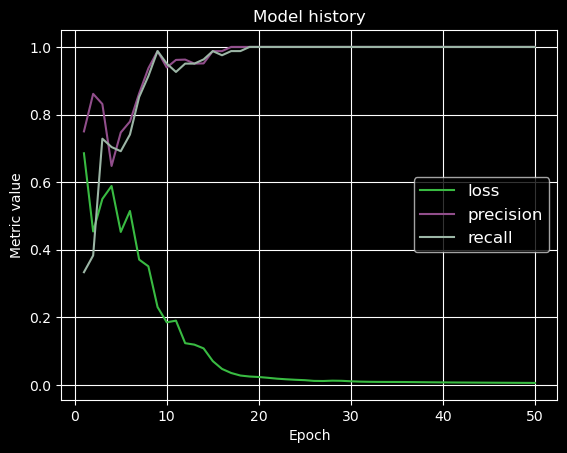

In [43]:
plot_history(history)
del history

In [44]:
evaluate(test_data, model)

Recall: 1.0, Precision: 1.0
Confusion matrix:
[[23  0]
 [ 0 27]]


<a name="upload"></a>
#### 6. **Выгрузка модели**

In [45]:
def copy_files_to_app(update=True):
    """Copy trained model and positive images to the app storage ('app/src/data/registered').
    
    Attributes
    ----------
    update: bool, default=True
        Whether or not to update destination path.
    """
    app_source_path = pathlib.Path('app/src')
    cascades_path   = pathlib.Path('cascades')
    model_path      = pathlib.Path('fr_model.tflite')
    data_path       = pathlib.Path('data')
    
    
    if update:
        try:
            shutil.rmtree(app_source_path / data_path)
            shutil.rmtree(app_source_path / cascades_path)
        except FileNotFoundError:
            pass
            
    shutil.copytree(data_path, app_source_path / data_path)
    shutil.copytree(cascades_path, app_source_path / cascades_path)
    shutil.copy(model_path, app_source_path / model_path)

In [46]:
model.save('fr_model')
converter = tf.lite.TFLiteConverter.from_saved_model('fr_model')
tflite_model = converter.convert()

with open('fr_model.tflite', 'wb') as f:
    f.write(tflite_model)
del model

INFO:tensorflow:Assets written to: fr_model/assets


INFO:tensorflow:Assets written to: fr_model/assets
2022-12-07 07:36:24.570894: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-07 07:36:24.570922: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.


In [47]:
copy_files_to_app()

<a name="real-time"></a>
#### 7. **Проверка на реальном примере**

In [35]:
def verify(input_image: np.ndarray | tf.Tensor, detection_threshold: float, verification_threshold: float) -> (list, int):
    """Verify input_image similarity with the 'data/registered/*' images.
    
    Attributes
    ----------
    input_image: np.ndarray | tf.Tensor
        The snap made to compare with 'data/registered/*' images.
    detection_threshold: float
        The threshold at which the result is acceptable to be varified for a single image.
    verification_threshold: float
        The threshold at which the result is acceptable to be varified for the sum of fractions of all images.
    
    Returns
    -------
    list: the results of verifications for each image.
    int: 0 or 1. Whether the input_image is verified or not.
    """
    outputs     = []
    input_image = DataPreprocessor.augment_image(input_image)
    
    for positive_image in positive_images:
        positive_image = DataPreprocessor.augment_image(positive_image)
        output         = model.predict(list(np.expand_dims([input_image, positive_image], axis=1)), verbose=0)
        outputs.append(output)
    
    detection    = np.sum(np.array(outputs) > detection_threshold)
    verification = detection / len(positive_images)
    verification = verification > verification_threshold
    
    return outputs, verification

In [36]:
data_loader = DataLoader()
positive_images, _, _ = data_loader.load('positive')
model = tf.keras.models.load_model('fr_model', custom_objects={'DistanceL2': DistanceL2, 'OneHand': OneHand})

In [ ]:
cam = cv2.VideoCapture(cv2.CAP_ANY)

while cam.isOpened():
    _, frame = cam.read()
    frame = np.flip(frame, axis=1)
    
    cv2.imshow('Verification', frame)
    x1, y1, x2, y2 = get_faces(frame)
    
    if cv2.waitKey(1) & 0xFF == ord('v'):
        if x1 and y1 and x2 and y2:
            outputs, verification = verify(frame[y1:y2, x1:x2], 0.5, 0.5)
            print(verification)
    elif cv2.waitKey(1) & 0xFF == ord('q'):
        cam.release()

cv2.destroyAllWindows()

In [38]:
cam.release()
cv2.destroyAllWindows()